# **Redes Convolucionales**
### Por **Josmar Dominguez** (16-10315)

## Entrenamiento de red neuronal convolucional
Este notebook se encarga de importar los datos de entrenamiento y testeo, entrenar la red neuronal convolucional y guardar los parametros de la red entrenada.

#### **Importar librerías**
Se importan las librerías a emplear,
* ```torch``` para el manejo de la red neuronal
* ```torchvision``` para la importación de los datos
* ```matplotlib``` para la visualización de los datos

In [1]:
# Import libraries and model
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from models.vgg16 import VGG16

#### **Importar datos**
Se importan los datos de entrenamiento y testeo y se crean los *dataloaders* para el entrenamiento y testeo.

In [8]:
# Specify the path to the .pt file
file_path = 'data/train_data_aug.pt'

# Load the train data
try:
    train_data = torch.load(file_path)
except:
    print('File not found. Please, run the _data_ notebook first.')

# Load the test data
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create a dictionary to map the labels to the class names
dict_labels = test_data.class_to_idx
dict_ids = {v: k for k, v in dict_labels.items()}



Files already downloaded and verified


Number of training images: 100000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


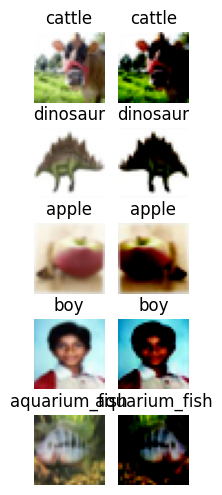

In [3]:
# Verify the number of images in the training dataset
print(f'Number of training images: {len(train_data)}')

# Show the first 5 images with their transformed versions
fig, ax = plt.subplots(5, 2, figsize=(2, 6))
for i in range(5):
    ax[i][0].imshow(train_data[i][0].permute(1, 2, 0))
    ax[i][0].set_title(dict_ids[train_data[i][1]])
    ax[i][0].axis("off")
    ax[i][1].imshow(train_data[i + len(train_data) // 2][0].permute(1, 2, 0))
    ax[i][1].set_title(dict_ids[train_data[i + len(train_data) // 2][1]])
    ax[i][1].axis("off")
plt.show()

In [4]:
# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Verify the size of the data loaders
print(f'Number of batches in the train loader: {len(train_loader)}')
print(f'Number of batches in the test loader: {len(test_loader)}')

Number of batches in the train loader: 1563
Number of batches in the test loader: 157


#### **Entrenamiento de la red**
Se crea una función para entrenar una red con el ```train_loader```

In [5]:
def train_model(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    epochs: int,
    device: str = "cpu",
) -> None:
    """
    Make backpropagation and update the parameters of the model.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    dataloader : torch.utils.data.DataLoader
        The dataset to use for training.
    epochs : int

        The number of epochs to train the model.
    device : str
        The device to use for training.
    """
    # Verify that model has parameters and methods
    atributes_needed = [
        "loss",
        "actual_loss",
        "actual_corrects",
        "cost",
        "epochs_printed",
        "acc",
    ]
    methods_needed = ["forward", "backward"]
    for atribute in atributes_needed:
        assert hasattr(
            model, atribute
        ), f"Model does not have the attribute {atribute}."
    for method in methods_needed:
        assert hasattr(model, method), f"Model does not have the method {method}."

    # If all ok, show message
    print("✅ Model has all the needed parameters and methods.")

    # Train
    for epoch in range(epochs):
        model.actual_loss = 0
        model.actual_corrects = 0

        for batch in dataloader:
            x, y = batch
            model.actual_loss += model.backward(x.to(device), y.to(device), epoch)

        model.acc.append(model.actual_corrects / (len(dataloader) * batch_size))
        model.cost.append(model.actual_loss / (len(dataloader) * batch_size))
        print(
            f"Epoch {epoch + 1} - Cost: {model.cost[-1]:.4f} | Acc: {model.acc[-1]:.4f}"
        )
        print("-" * 50)

Para visualizar el resultado del entrenamiento se define una función para graficar la función de pérdida y nivel de certeza del modelo

In [6]:
def plot_cost_acc(model: nn.Module) -> None:
    """
    Plot the cost and accuracy of the model.

    Parameters
    ----------
    model : nn.Module
        The model to plot.

    Returns
    -------
    None
        The plot of the cost and accuracy of the model.
    """
    # Verify that model has parameters and methods
    atributes_needed = [
        "cost",
        "acc",
    ]
    for atribute in atributes_needed:
        assert hasattr(
            model, atribute
        ), f"Model does not have the attribute {atribute}."

    # Plot cost and accuracy
    fig, ax1 = plt.subplots()

    color = "tab:red"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Cost", color=color)
    ax1.plot(model.cost, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = "tab:blue"
    ax2.set_ylabel("Accuracy", color=color) 
    ax2.plot(model.acc, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()
    plt.show()

##### **VGG16**

✅ Model has all the needed parameters and methods.


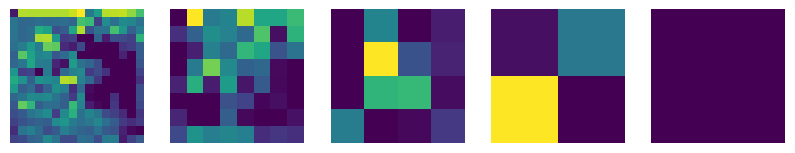

KeyboardInterrupt: 

In [7]:
# Import the model
model_vgg16 = VGG16()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
train_model(model_vgg16, train_loader, 30, device)

#### **Análisis superficial de entrenamiento**
Se grafica la función de costo y el nivel de certeza del modelo después del entranamiento.